In [18]:
import PhysicalConstants.CODATA2018: c_0
using CollectiveSpins
using JLD2
using Unitful
using QuantumOptics
using PyPlot
using LinearAlgebra
using OrdinaryDiffEq

# System

In [8]:
# Nbr of particles
N = 8

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Load atom position
@load "r0.jdl2"

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
r0 = r0 / λ
Ω = Ω / γ

# Compute the Ω and Γ matrices of the electric dipole-dipole interaction using CollectiveSpins
e = [0, 0, 1.] # Quantization axis along z
system = SpinCollection(r0, e, gammas=1.)
Ω_CS = interaction.OmegaMatrix(system)
Γ_CS = interaction.GammaMatrix(system)

# Integration parameter
tstep = 0.1
T = [0:tstep:10;]; # Normalised time

# Compute QuantumOptics

In [9]:
# Basis
b1 = SpinBasis(1//2)
bmb = tensor([b1 for i = 1:N]...)

# One body operators
σp = sigmap(b1)
σm = sigmam(b1)
#σz = sigmaz(b1)
nup = σp*σm
ndown = σm*σp

# Many body operators
Jz =sum([embed(bmb, i, -8*ndown) for i = 1:N]) + sum([embed(bmb, i, -9*nup) for i = 1:N]) # 2 level system but GS has mJ = -8, ES has mJ = -9
Nup = sum([embed(bmb, i, nup) for i = 1:N]);

In [10]:
HRO = -Ω/2 * (sum([exp(1im*r0[i]'kl)*embed(bmb, i, σp) + exp(-1im*r0[i]'kl)*embed(bmb, i, σm) for i = 1:N]))
H_elec = sum([sum([Ω_CS[i, j]*embed(bmb, i, σp)*embed(bmb, j, σm) for j = 1:N if i≠j]) for i = 1:N]);
J = [embed(bmb, i, σm) for i = 1:N];

In [16]:
Ψ0_mb = tensor([spindown(b1) for i = 1:N]...)
ρt_elec_QO = timeevolution.master(T, Ψ0_mb, HRO + H_elec, J; rates=Γ_CS, dt=tstep)[2];

# Compute QuantumCumulants

In [28]:
@load "op_list.jdl2" op_list
u0 = zeros(length(op_list)); # Start from spindown
fsolve(du, u, p, t) = ccall(("diffeqf", "liballfuncs.dll"), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}), du, u);

In [ ]:
prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
            reltol=1.0e-6,
            abstol=1.0e-8).u;

In [ ]:
@save "Sol_QC_Nx_(Nx)_Ny_(Ny)_Nz_(Nz)_theta_(round(theta_init, digits=1))_phi_(phi_init)_thetal_(round(θl, digits=2))" sol

In [ ]:
mean_σx_QC = [2*mean(real(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σy_QC = [2*mean(imag(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 8; # Map the spin values along z: [-1, 1] -> [-6, -7]

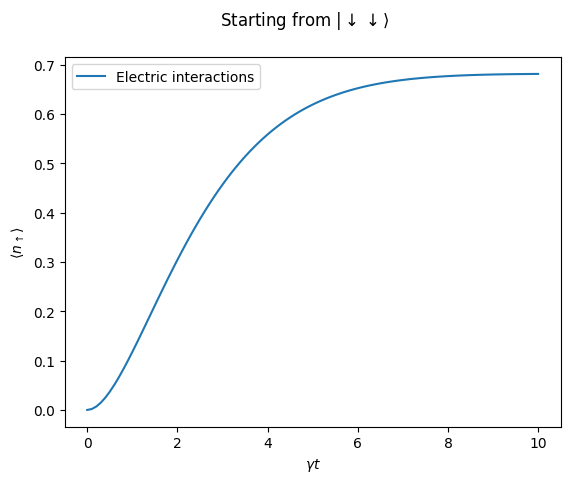

In [17]:
figure()
plot(T, real(expect(Nup, ρt_elec_QO)), label="Electric interactions")
# plot(T, real(expect(Nup, ρt_ρt_elec_QOindep)), label="Independant case")
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
#pygui(true); show()

# Brouillons

In [ ]:
# """ Prepare the initial state of the system 
# with a phase correlation imposed between the atoms
# by the laser, which arrive on the lattice with an angle θl """
# function prepare_phi_IS(θl, λl, theta_array)
#     phi_array = zeros(N)
#     for i = 1:N
#         phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
#     end
#     return phi_array
# end

# """ Prepare the initial vector u0 """
# function u0_CFunction(phi_array, theta_array, op_list)
#     u0 = ones(ComplexF64, length(op_list))
#     for i in 1:length(op_list)
#         if length(op_list[i]) == 1
#             j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
#             if parse(Int, string(op_list[i][1])[1:2]) == 22
#                 u0[i] = cos(theta_array[j]/2)^2
#             elseif parse(Int, string(op_list[i][1])[1:2]) == 21
#                 u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
#             else
#                 println(op_list[i][1])
#             end
#         end

#         if length(op_list[i]) == 2
#             for op in op_list[i]
#                 j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
#                 if parse(Int, string(op)[1:2]) == 22
#                     u0[i] *= cos(theta_array[j]/2)^2
#                 elseif parse(Int, string(op)[1:2]) == 21
#                     u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
#                 elseif parse(Int, string(op)[1:2]) == 12
#                     u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
#                 else
#                     println(op)
#                 end
#             end
#         end
#     end
#     return u0
# end